# INFO 3401 – Class 23: Spatial data fundamentals

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT).

## Learning Objectives
This lecture will introduce forecasting, one of the most common data analysis tasks when working with time series data.

* Using shapely and fundamentals of geometric objects
* Reading and writing spatial data
* Filtering spatial data in GeoPandas
* Visualizing spatial data and using different projections

## Background

This module will explore how to acquire, analyze, and visualize spatial data. I have adapted this content from the excellent course [Auotmating GIS processes](https://automating-gis-processes.github.io/site/index.html) course by [Vuokko Heikinheimo](https://researchportal.helsinki.fi/en/persons/vuokko-vilhelmiina-heikinheimo) and [Henrikki Tenkanen](https://www.ucl.ac.uk/geospatial-analytics/people/henrikki-tenkanen).

### Install new libraries

Analyzing spatial data requires a few libraries that aren't installed with Anaconda by default. The ecosystem of spatial data libraries within Python is infamously decentralized and there are a dozen or more dependencies that need to be installed. Make sure your notebooks are saved and [close them down](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/execute.html#shut-down-the-jupyter-notebook-app).

**At the terminal**, install [geopandas](https://geopandas.org/index.html) and [geoplot](https://residentmario.github.io/geoplot/index.html):

`conda install geopandas geoplot -c conda-forge`

Then do a `conda update --all` for good measure.

## Load libraries

Load our usual libraries.

In [1]:
# Data processing libraries
import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

# Visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

Import a few of our new libraries.

In [2]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon

## Geometric objects

We are not going to be constructing map geometries by hand any more than we are going to make DataFrames cell-by-cell. However, it's still important to know more about the fundamental geometric objects used for making maps in Python. [Shapely](https://shapely.readthedocs.io/en/stable/manual.html) is one library for represential spatial geometries of points, lines, and polygons (among other possible geometries).

* A `Point` is a single point in (usually two-dimensional) space: `(x,y)`
* A `LineString` is a sequence of at least two points that form a line: `[(x0,y0),(x1,y1)]`
* A `Polygon` is a sequence of at least three points that forms an enclosed area: `[(x0,x1),(x1,y1),(x2,y2)]`

After defining a geometry in some space, calling that object will return a visualization.

### Point
Make a `Point` at position (1,2) and display it.

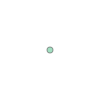

In [3]:
point0 = Point(1,2)
point0

Print the object.

In [4]:
print(point0)

POINT (1 2)


Confirm the type of geometry of the object.

In [5]:
point0.geom_type

'Point'

Access its coordinates as an attribute.

In [6]:
point0.x

1.0

In [7]:
point0.y

2.0

Make another `Point` at (4,2) and calculate the distance between the two points.

In [8]:
point1 = Point(4,2)

Make a third point at (-2,-2).

In [9]:
point2 = Point(-2,-2)

### LineString

Make a `LineString` of the three points you defined above. Display the `LineString`.

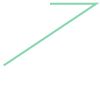

In [10]:
line0 = LineString([point0,point1,point2])
line0

Note that the order of the points matters.

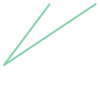

In [11]:
line1 = LineString([point0,point2,point1])
line1

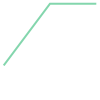

In [12]:
line2 = LineString([point2,point0,point1])
line2

Confirm the type of geometry.

In [13]:
line0.geom_type

'LineString'

Access its coordinates. Note that the x-coordinates are in first array and the y-coordinates are in the second array.

In [14]:
line0.xy

(array('d', [1.0, 4.0, -2.0]), array('d', [2.0, 2.0, -2.0]))

Compute the length.

In [15]:
line0.length

10.21110255092798

### Polygon

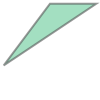

In [16]:
poly0 = Polygon([point0,point1,point2])
poly0

Confirm the geometry type.

In [17]:
poly0.geom_type

'Polygon'

The centroid is the center of the three points.

In [19]:
poly0.centroid.xy

(array('d', [1.0]), array('d', [0.6666666666666666]))

## Reading spatial data

There are many standards and file formats for storing and sharing spatial data. Shapefiles are one of the most common standards and the default used by geopandas's [`read_file`](https://geopandas.org/reference/geopandas.read_file.html#geopandas.read_file) function.

* The U.S. Census bureau publishes official national-level spatial data files for a variety of boundary types: [TIGER/Line Shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) and [Cartographic Boundary Files](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)
* Eric Celeste's has some of the Census Bureau's shapefiles converted to KML and GeoJSON: [GeoJSON and KML Data for the United States](https://eric.clst.org/tech/usgeojson/)
* Many states, counties, and cities publish detailed GIS data about their jurisdictions:  
  * [Official State of Colorado GIS data](https://demography.dola.colorado.gov/gis/gis-data/#gis-data); [ColoradoView](https://www.coloradoview.org/colorado-gis/)
  * [Offical Boulder County GIS data](https://opendata-bouldercounty.hub.arcgis.com/)
  * [Offical City of Boulder GIS data](https://bouldercolorado.gov/open-data/tag/gis)

The resulting data looks a lot like a normal pandas DataFrame but there's always a "geometry" column that contains a `Polygon` or analogous (*e.g.*, `MultiPolygon`) geometry. Sometimes there's lots of associated metadata about the geometry like names, identifiers, abbreviations, sizes, populations, *etc.* associated with the geometry, other times it's just a name and the geometry.

International and national datasets are often offered at different resolutions, we'll talk more about these trade-offs when we get to visualization.

### Shapefiles
[Shapefiles](https://en.wikipedia.org/wiki/Shapefile) are actually a collection of files generally shared as ZIP files. You cannot read in the ZIP file directly and will need to unzip it to a sub-directory. I have downloaded the 2019 State layer from the [U.S. Census TIGER/Line](https://www.census.gov/cgi-bin/geo/shapefiles/index.php) shapefile and unzipped it to a new sub-directory "us_states". I only read the `.shp` filename which automatically grabs the other data in the directory as well.

In [7]:
# Read in and assign data to a variable
us_states_gdf = gpd.read_file('us_states/tl_2019_us_state.shp')

# Inspect
us_states_gdf.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266231560,489271086,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138947364717,31362872853,+28.4574302,-082.4091477,"MULTIPOLYGON (((-86.38865 30.99418, -86.38385 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143779863817,6215723896,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206230065476,18942261495,+46.3159573,-094.1996043,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151726296,6979340970,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


### GeoJSON

Working with ZIP files and sub-directories can be a pain, so standards like [GeoJSON]() provide an alternative way for storing and sharing data. Make sure to invoke the "driver='GeoJSON'" parameter for `read_file`. Like pandas's `read_csv`, GeoPandas's `read_file` can read directly from the web.

In [3]:
# Get the data directly from: https://eric.clst.org/tech/usgeojson/
us_states_geojson_gpd = gpd.read_file('https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_20m.json',driver='GeoJSON')

us_states_geojson_gpd.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
1,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
2,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-120.24848 33.99933, -120.2473..."
3,0400000US08,08,Colorado,,103641.888,"POLYGON ((-107.31779 41.00296, -107.00061 41.0..."
4,0400000US09,09,Connecticut,,4842.355,"POLYGON ((-72.39743 42.03330, -72.19883 42.030..."


Here's a file with the shapes of all the countries in the world.

In [4]:
countries_geojson_gpd = gpd.read_file('https://github.com/datasets/geo-countries/raw/master/data/countries.geojson',driver='GeoJSON')

countries_geojson_gpd.head()


,ADMIN,ISO_A3,ISO_A2,geometry
0,Aruba,ABW,AW,"MULTIPOLYGON (((-69.99694 12.57758, -69.93639 ..."
1,Afghanistan,AFG,AF,"MULTIPOLYGON (((71.04980 38.40866, 71.05714 38..."
2,Angola,AGO,AO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,AI,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,AL,"MULTIPOLYGON (((19.74777 42.57890, 19.74601 42..."


## Filtering spatial data in GeoPandas

Inspect the `us_states_shp_gdf` file we read in above.

In [8]:
us_states_gdf.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266231560,489271086,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138947364717,31362872853,+28.4574302,-082.4091477,"MULTIPOLYGON (((-86.38865 30.99418, -86.38385 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143779863817,6215723896,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206230065476,18942261495,+46.3159573,-094.1996043,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151726296,6979340970,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


Summarize the different columns.

In [9]:
us_states_gdf['REGION'].value_counts()

3    17
4    13
2    12
1     9
9     5
Name: REGION, dtype: int64

In [10]:
us_states_gdf['DIVISION'].value_counts()

5    9
8    8
4    7
1    6
3    5
0    5
9    5
7    4
6    4
2    3
Name: DIVISION, dtype: int64

In [11]:
us_states_gdf.shape

(56, 15)

In [12]:
us_states_gdf['NAME'].unique()

array(['West Virginia', 'Florida', 'Illinois', 'Minnesota', 'Maryland',
       'Rhode Island', 'Idaho', 'New Hampshire', 'North Carolina',
       'Vermont', 'Connecticut', 'Delaware', 'New Mexico', 'California',
       'New Jersey', 'Wisconsin', 'Oregon', 'Nebraska', 'Pennsylvania',
       'Washington', 'Louisiana', 'Georgia', 'Alabama', 'Utah', 'Ohio',
       'Texas', 'Colorado', 'South Carolina', 'Oklahoma', 'Tennessee',
       'Wyoming', 'Hawaii', 'North Dakota', 'Kentucky',
       'United States Virgin Islands',
       'Commonwealth of the Northern Mariana Islands', 'Guam', 'Maine',
       'New York', 'Nevada', 'Alaska', 'American Samoa', 'Michigan',
       'Arkansas', 'Mississippi', 'Missouri', 'Montana', 'Kansas',
       'Indiana', 'Puerto Rico', 'South Dakota', 'Massachusetts',
       'Virginia', 'District of Columbia', 'Iowa', 'Arizona'],
      dtype=object)

Find the row for Colorado.

In [13]:
us_states_gdf[us_states_gdf['NAME'] == 'Colorado']

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
26,4,8,08,01779779,08,CO,Colorado,00,G4000,A,268419875371,1184637800,+38.9938482,-105.5083165,"POLYGON ((-109.05095 40.22265, -109.05097 40.2..."


There are different attributes on a GeoSeries. Two of the most relevant are `area` and `centroid`

* `.area` - computes the area of each row's Polygon
* `.centroid` - returns the centroid of each row's Polygon

In [14]:
us_states_gdf['geometry'].centroid

<ipython-input-14-578036b7b16b>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_states_gdf['geometry'].centroid


0       POINT (-80.61371 38.64257)
1       POINT (-82.46642 28.47706)
2       POINT (-89.14864 40.12420)
3       POINT (-94.19835 46.34929)
4       POINT (-76.68718 38.94649)
5       POINT (-71.52472 41.59464)
6      POINT (-114.65941 44.38905)
7       POINT (-71.57124 43.68024)
8       POINT (-79.13088 35.52604)
9       POINT (-72.66263 44.07525)
10      POINT (-72.73826 41.57516)
11      POINT (-75.45249 38.99497)
12     POINT (-106.10844 34.42130)
13     POINT (-119.66387 37.21533)
14      POINT (-74.65561 40.11018)
15      POINT (-89.73297 44.63994)
16     POINT (-120.60526 43.94045)
17      POINT (-99.81086 41.52715)
18      POINT (-77.83894 40.89670)
19     POINT (-120.59282 47.41162)
20      POINT (-91.81423 30.90907)
21      POINT (-83.42725 32.63864)
22      POINT (-86.84452 32.75688)
23     POINT (-111.67825 39.32377)
24      POINT (-82.70938 40.41549)
25      POINT (-99.31712 31.44720)
26     POINT (-105.54782 38.99853)
27      POINT (-80.86459 33.87775)
28      POINT (-97.5

## Projections

The warnings (red boxes) we got by accessing the attributes above reference a need to use a "CRS". 

What's a CRS? CRS refers to a "coordinate reference system" and is a way of defining map projections. 

What's a [map projection](https://en.wikipedia.org/wiki/Map_projection)? Trying to represent a 3D surface in 2D requires some compromises in accuracy in some kind of way and has been an area of research within geography for centuries. 

[xkcd comic 977](https://xkcd.com/977/) summarizes some of the more common projections. [S02E16 of *The West Wing*](https://www.youtube.com/watch?v=OH1bZ0F3zVU) has a nice scene about map projections as well.

What kinds of map projections are available? A *lot*—again this has been an active area of research within geography for centuries with lots of strongly-held preferences and critiques.

* [Proj.org](https://proj.org/operations/projections/)
* [SpatialReference.org](https://spatialreference.org/)
* [Choosing the Right Map Projection](https://source.opennews.org/articles/choosing-right-map-projection/)
* [List of map projections](https://en.wikipedia.org/wiki/List_of_map_projections)
* [Compare Map Projections](https://map-projections.net/)

Inspect the current CRS for any of the files we have read in above using the `.crs` attribute on the GeoDataFrame.

In [15]:
us_states_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [16]:
countries_geojson_gpd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### EPSG IDs
The most commonly used (but not necessarily the best) projection is the [World Geodetic System](https://en.wikipedia.org/wiki/World_Geodetic_System), also known as WGS84, also known as EPSG:4326. The popular (but terrible) [Web Mercator projection](https://en.wikipedia.org/wiki/Web_Mercator_projection) (found in Google Maps, *etc*.) is stored as EPSG:3857.

We can convert between projections using the `.to_crs()` method on a GeoDataFrame.

<AxesSubplot:>

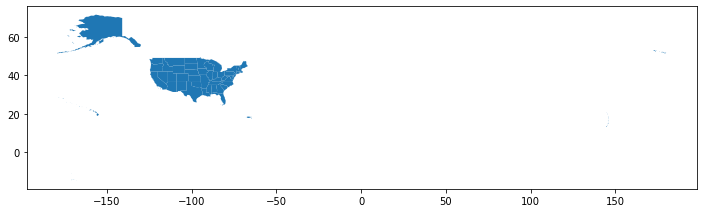

In [17]:
us_states_gdf.plot(figsize=(12,6))

<AxesSubplot:>

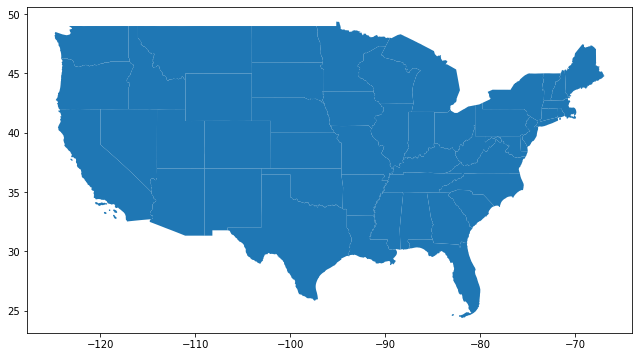

In [18]:
lower48 = us_states_gdf[~us_states_gdf['STUSPS'].isin(['AK','HI','GU','MP','VI','PR','AS'])]
lower48.plot(figsize=(12,6))

In [19]:
lower48.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

When we change the projection, the definitions of the polygons change, which can also drastically change other calculated attributes like area, centroids, and distance.

In [23]:
# WGS84
lower48_epsg4326 = lower48.to_crs(epsg='4326')

In [21]:
lower48_epsg4326['geometry']

0     POLYGON ((-81.74725 39.09538, -81.74635 39.096...
1     MULTIPOLYGON (((-86.38865 30.99418, -86.38385 ...
2     POLYGON ((-91.18529 40.63780, -91.17510 40.643...
3     POLYGON ((-96.78438 46.63050, -96.78434 46.630...
4     POLYGON ((-77.45881 39.22027, -77.45866 39.220...
5     MULTIPOLYGON (((-71.78970 41.72520, -71.78971 ...
6     POLYGON ((-116.89971 44.84061, -116.89967 44.8...
7     POLYGON ((-72.32990 43.60021, -72.32984 43.600...
8     POLYGON ((-82.41674 36.07283, -82.41660 36.073...
9     POLYGON ((-73.31328 44.26413, -73.31274 44.265...
10    POLYGON ((-73.51808 41.66672, -73.51807 41.666...
11    POLYGON ((-75.76007 39.29682, -75.76010 39.297...
12    POLYGON ((-106.00632 36.99527, -106.00531 36.9...
13    MULTIPOLYGON (((-124.13656 41.46445, -124.1378...
14    POLYGON ((-75.18960 40.59178, -75.18977 40.592...
15    POLYGON ((-92.88707 45.64415, -92.88671 45.644...
16    POLYGON ((-124.06545 45.78305, -124.06206 45.7...
17    POLYGON ((-104.05264 42.00172, -104.05263 

<AxesSubplot:>

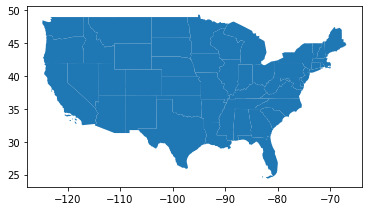

In [24]:
lower48_epsg4326.plot()

In [25]:
# National Atlas Equal Area
lower48_epsg2163 = lower48.to_crs(epsg='2163')
lower48_epsg2163.crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

<AxesSubplot:>

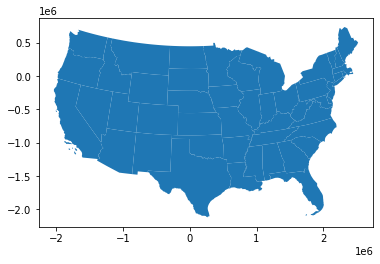

In [26]:
lower48_epsg2163.plot()

In [27]:
lower48_epsg2163['geometry']

0     POLYGON ((1561571.961 -483477.971, 1561619.813...
1     MULTIPOLYGON (((1300534.538 -1450505.843, 1300...
2     POLYGON ((742564.486 -445238.183, 743359.700 -...
3     POLYGON ((245479.802 186204.457, 245483.060 18...
4     POLYGON ((1914704.978 -379436.546, 1914710.426...
5     MULTIPOLYGON (((2284754.210 36016.088, 2284698...
6     POLYGON ((-1320390.644 120880.552, -1320386.43...
7     POLYGON ((2174741.054 220735.669, 2174745.020 ...
8     POLYGON ((1570933.077 -826582.735, 1570940.814...
9     POLYGON ((2077303.749 265450.633, 2077297.944 ...
10    POLYGON ((2153209.083 -17580.644, 2153207.748 ...
11    POLYGON ((2051669.129 -330166.879, 2051656.712...
12    POLYGON ((-534160.606 -870239.336, -534071.660...
13    MULTIPOLYGON (((-1976210.177 -98944.190, -1976...
14    POLYGON ((2057259.261 -176271.933, 2057234.614...
15    POLYGON ((552058.173 95955.669, 552081.771 960...
16    POLYGON ((-1831536.295 364072.673, -1831066.61...
17    POLYGON ((-334822.281 -325088.607, -334816

In [28]:
# Web Mercator
lower48_epsg3857 = lower48.to_crs(epsg='3857')
lower48_epsg3857.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

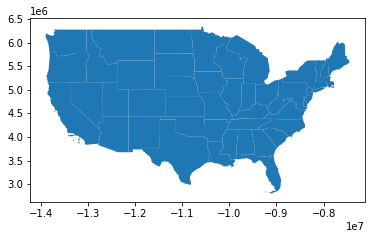

In [29]:
lower48_epsg3857.plot()

In [30]:
# Polar Stereographic
lower48_epsg3995 = lower48.to_crs(epsg='3995')
lower48_epsg3995.crs

<Projected CRS: EPSG:3995>
Name: WGS 84 / Arctic Polar Stereographic
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: World - N hemisphere - north of 60°N
- bounds: (-180.0, 60.0, 180.0, 90.0)
Coordinate Operation:
- name: Arctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

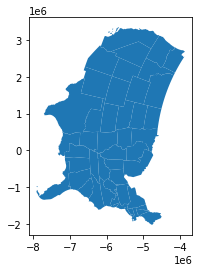

In [31]:
lower48_epsg3995.plot()

In [37]:
lower48_epsg2163.loc[0]

REGION                                                      3
DIVISION                                                    5
STATEFP                                                    54
STATENS                                              01779805
GEOID                                                      54
STUSPS                                                     WV
NAME                                            West Virginia
LSAD                                                       00
MTFCC                                                   G4000
FUNCSTAT                                                    A
ALAND                                             62266231560
AWATER                                              489271086
INTPTLAT                                          +38.6472854
INTPTLON                                         -080.6183274
geometry    POLYGON ((1561571.961498005 -483477.9709532264...
Name: 0, dtype: object

In [ ]:
lower48_epsg2163.head()

In [38]:
lower48_epsg2163['geometry'].area

0     6.270846e+10
1     1.705538e+11
2     1.498327e+11
3     2.246024e+11
4     3.210473e+10
5     3.995714e+09
6     2.159931e+11
7     2.416970e+10
8     1.393826e+11
9     2.485456e+10
10    1.433763e+10
11    6.440554e+09
12    3.149869e+11
13    4.237900e+11
14    2.256813e+10
15    1.692747e+11
16    2.542965e+11
17    2.000453e+11
18    1.191278e+11
19    1.841532e+11
20    1.357788e+11
21    1.539942e+11
22    1.358426e+11
23    2.196867e+11
24    1.159635e+11
25    6.962383e+11
26    2.693810e+11
27    8.296648e+10
28    1.810267e+11
29    1.091399e+11
30    2.528819e+11
32    1.825954e+11
33    1.046029e+11
37    9.142387e+10
38    1.410507e+11
39    2.861168e+11
42    2.499395e+11
43    1.377454e+11
44    1.255312e+11
45    1.804155e+11
46    3.798095e+11
47    2.129475e+11
48    9.422913e+10
50    1.993119e+11
51    2.729233e+10
52    1.107317e+11
53    1.768840e+08
54    1.455209e+11
55    2.952862e+11
dtype: float64

In [36]:
lower48_epsg3995['geometry'].area.head()

0    8.995173e+10
1    2.955948e+11
2    2.099934e+11
3    2.871338e+11
4    4.581904e+10
dtype: float64

### PROJ strings
In addition to EPSG standards, projections can be defined by standardized "[PROJ](https://proj.org/usage/quickstart.html)" strings. These are available within [SpatialReference.org](https://spatialreference.org/). We'll need to import a library called [pyproj](https://pyproj4.github.io/pyproj/stable/) that (hopefully) should've been installed when you installed GeoPandas.

In [39]:
from pyproj import CRS

First, let's take a global map like `countries_geojson_gpd` and inspect its default projection using the `.crs` attribute.

In [40]:
countries_geojson_gpd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now let's plot it.

<AxesSubplot:>

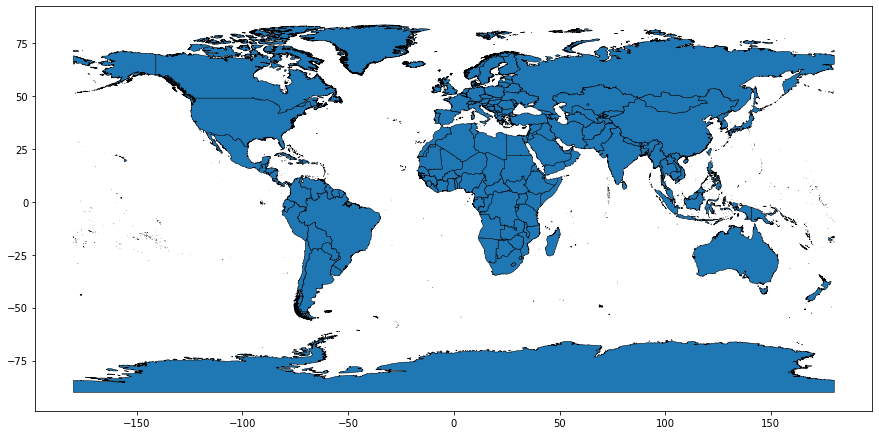

In [47]:
countries_geojson_gpd.plot(edgecolor='k',lw=.5,figsize=(15,10))

Use the `CRS` function to retrieve the Web Mercator projection by EPSG ID.

In [48]:
countries_mercator_gpd = countries_geojson_gpd.to_crs(epsg='3785')
countries_mercator_gpd.crs

<Projected CRS: EPSG:3785>
Name: Popular Visualisation CRS / Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Mercator
- method: Mercator (1SP) (Spherical)
Datum: Popular Visualisation Datum
- Ellipsoid: Popular Visualisation Sphere
- Prime Meridian: Greenwich

<AxesSubplot:>

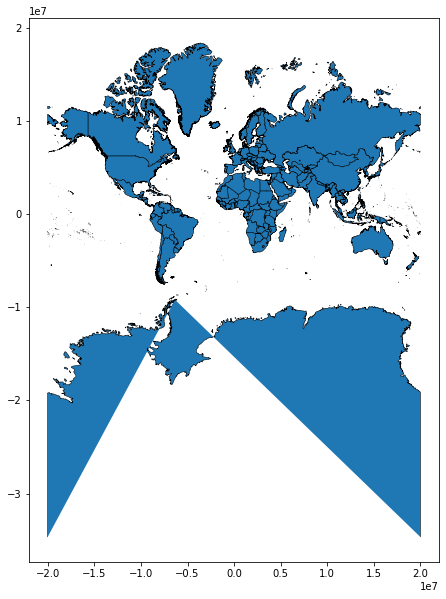

In [50]:
countries_mercator_gpd.plot(edgecolor='k',lw=.5,figsize=(15,10))

In [52]:
web_mercator = CRS.from_epsg(3785)

This `web_mercator` is *not* a GeoPandas DataFrame or Series, but a definition of a projection. Inspect the `web_mercator` object.

In [53]:
web_mercator

<Projected CRS: EPSG:3785>
Name: Popular Visualisation CRS / Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Mercator
- method: Mercator (1SP) (Spherical)
Datum: Popular Visualisation Datum
- Ellipsoid: Popular Visualisation Sphere
- Prime Meridian: Greenwich

Use the `.to_crs` method with the `web_mercator` on the `countries_geojson_gpd` GeoDataFrame to convert it and plot it.

<AxesSubplot:>

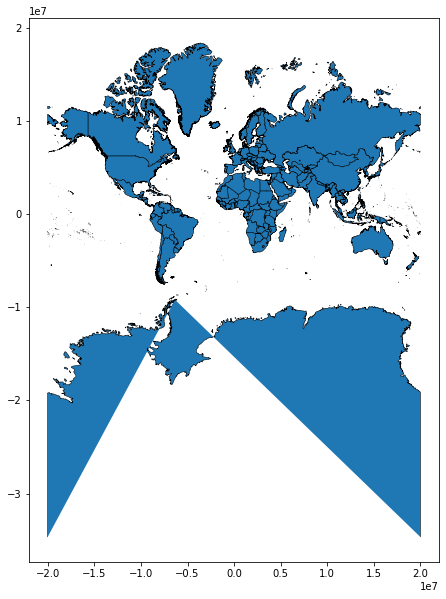

In [57]:
countries_geojson_gpd.to_crs(web_mercator).plot(edgecolor='k',lw=.5,figsize=(15,10))

Projections can be defined by more that EPSG IDs like the PROJ strings. Retrieve the PROJ string for the [Eckert IV](https://en.wikipedia.org/wiki/Eckert_IV_projection) projection from SpatialReference.org: https://spatialreference.org/ref/esri/54012/ and click on "Proj4"

<AxesSubplot:>

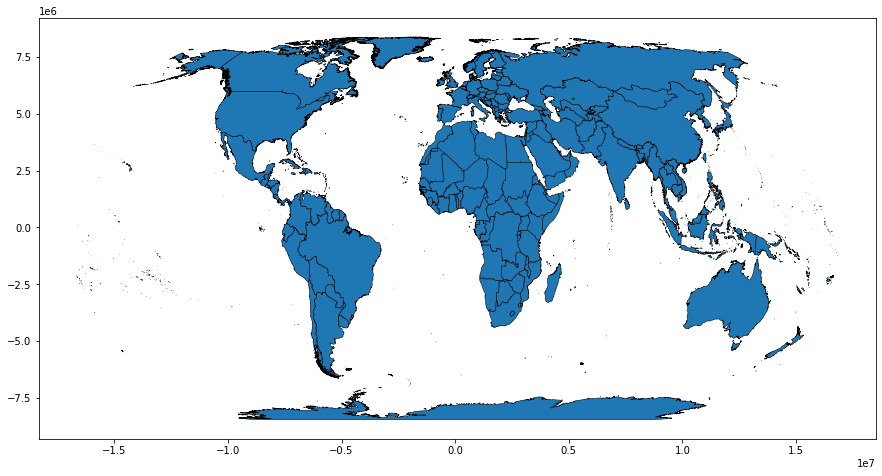

In [59]:
eckert_iv = CRS.from_proj4('+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs ')
countries_geojson_gpd.to_crs(eckert_iv).plot(edgecolor='k',lw=.5,figsize=(15,10))

We could also use an [orthographic projection](https://en.wikipedia.org/wiki/Orthographic_map_projection) approximately centered over Colorado. Here we can begin to customize what's in the PROJ string to see how it changes the map projection. More details here: http://www.statsmapsnpix.com/2019/09/globe-projections-and-insets-in-qgis.html

<AxesSubplot:>

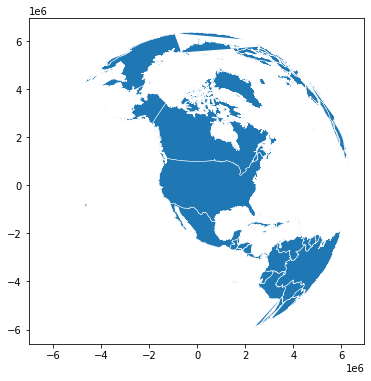

In [60]:
ortho = CRS.from_proj4("+proj=ortho +lat_0=40.00 +lon_0=-105.0000 +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs")

countries_geojson_gpd.to_crs(ortho).plot(edgecolor='w',lw=.5,figsize=(12,6))

We could also construct a CRS projection from other attributes. (Adapted from [Automating GIS Processes: "Calculating Distances"](https://automating-gis-processes.github.io/site/notebooks/L2/calculating-distances.html)

* `proj='aeqd'` refers to projection specifier that we determine to be Azimuthal Equidistant (‘aeqd’)
* `ellps='WGS84'` refers to the reference ellipsoid that is a mathematically modelled (based on measurements) surface that approximates the true shape of the world. World Geodetic System (WGS) was established in 1984, hence the name.
* `datum='WGS84'` refers to the Geodetic datum that is a coordinate system constituted with a set of reference points that can be used to locate places on Earth.
* `lat_0` is the latitude coordinate of the center point in the projection
* `lon_0` is the longitude coordinate of the center point in the projection

Figure out the center of Colorado specifically.

In [66]:
lower48.loc[26,'geometry'].centroid.xy

(array('d', [-105.54782080150963]), array('d', [38.99853203120936]))

Now make an [Azimuthal Equidistant](https://en.wikipedia.org/wiki/Azimuthal_equidistant_projection) projection centered on Colorado.

<AxesSubplot:>

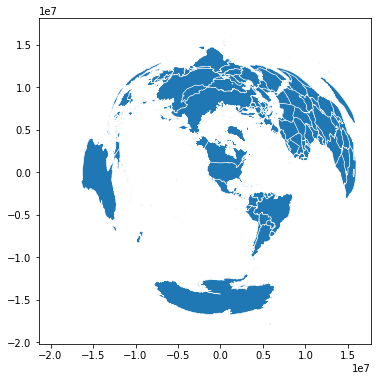

In [68]:
aeqd = CRS(proj='aeqd',ellps='WGS84',datum='WGS84',lat_0=38.9985,lon_0=-105.547).srs

countries_geojson_gpd.to_crs(crs=aeqd).plot(edgecolor='w',lw=.5,figsize=(12,6))

In [70]:
aeqd

'+proj=aeqd +ellps=WGS84 +datum=WGS84 +lat_0=38.9985 +lon_0=-105.547 +type=crs'

Try the `aeqd` projection on the `lower48` GeoDataFrame.

<AxesSubplot:>

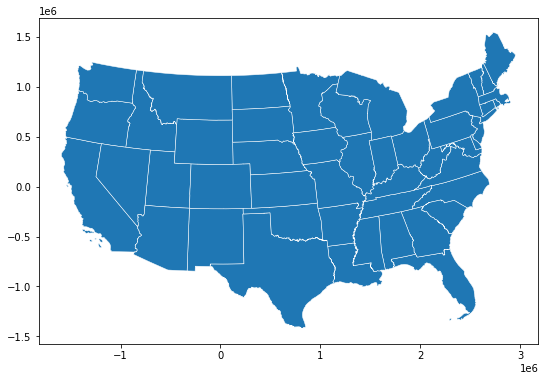

In [71]:
lower48.to_crs(crs=aeqd).plot(edgecolor='w',lw=.5,figsize=(12,6))

## Visualizing data: choropleths

Everything we've done to date has been dealing with the challenges of defining spatial data and how to represent a 3D surface on a 2D screen. Now let's work with some data. The most common kind of visualization when working with spatial data is a choropleth: color individual units by some other data value. We'll work with state-level U.S. Presidential election results since 1976.

Read in the "1976-2016-president.csv" file via pandas.

In [72]:
president_df = pd.read_csv('1976-2016-president.csv')
president_df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes
0,1976,Alabama,AL,1,63,41,US President,"Carter, Jimmy",democrat,False,659170,1182850,20171015,NaN
1,1976,Alabama,AL,1,63,41,US President,"Ford, Gerald",republican,False,504070,1182850,20171015,NaN
2,1976,Alabama,AL,1,63,41,US President,"Maddox, Lester",american independent party,False,9198,1182850,20171015,NaN
3,1976,Alabama,AL,1,63,41,US President,"Bubar, Benjamin """"Ben""""",prohibition,False,6669,1182850,20171015,NaN
4,1976,Alabama,AL,1,63,41,US President,"Hall, Gus",communist party use,False,1954,1182850,20171015,NaN


Filter the data to only Democrats and Republicans for the sake of simplicity.

In [75]:
filtered_president_df = president_df.copy()[president_df['party'].isin(['democrat','republican'])]
filtered_president_df

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes
0,1976,Alabama,AL,1,63,41,US President,"Carter, Jimmy",democrat,False,659170,1182850,20171015,NaN
1,1976,Alabama,AL,1,63,41,US President,"Ford, Gerald",republican,False,504070,1182850,20171015,NaN
7,1976,Alaska,AK,2,94,81,US President,"Ford, Gerald",republican,False,71555,123574,20171015,NaN
8,1976,Alaska,AK,2,94,81,US President,"Carter, Jimmy",democrat,False,44058,123574,20171015,NaN
11,1976,Arizona,AZ,4,86,61,US President,"Ford, Gerald",republican,False,418642,742719,20171015,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3719,2016,West Virginia,WV,54,55,56,US President,"Clinton, Hillary",democrat,False,188794,713051,20171015,NaN
3723,2016,Wisconsin,WI,55,35,25,US President,"Trump, Donald J.",republican,False,1405284,2976150,20171015,NaN
3724,2016,Wisconsin,WI,55,35,25,US President,"Clinton, Hillary",democrat,False,1382536,2976150,20171015,NaN
3732,2016,Wyoming,WY,56,83,68,US President,"Trump, Donald J.",republican,False,174419,258788,20171015,NaN


Calculate the "candidatevotes" as a percentage of the "totalvotes".

In [76]:
filtered_president_df['candidatepct'] = filtered_president_df['candidatevotes']/filtered_president_df['totalvotes']
filtered_president_df.tail()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes,candidatepct
3719,2016,West Virginia,WV,54,55,56,US President,"Clinton, Hillary",democrat,False,188794,713051,20171015,NaN,0.264769
3723,2016,Wisconsin,WI,55,35,25,US President,"Trump, Donald J.",republican,False,1405284,2976150,20171015,NaN,0.472182
3724,2016,Wisconsin,WI,55,35,25,US President,"Clinton, Hillary",democrat,False,1382536,2976150,20171015,NaN,0.464538
3732,2016,Wyoming,WY,56,83,68,US President,"Trump, Donald J.",republican,False,174419,258788,20171015,NaN,0.673984
3733,2016,Wyoming,WY,56,83,68,US President,"Clinton, Hillary",democrat,False,55973,258788,20171015,NaN,0.216289


Pivot the data so we get Democrat and Republican candidate vote percentages by state and year.

In [77]:
pivoted_president_df = pd.pivot_table(filtered_president_df,
                                      index=['year','state'],
                                      columns='party',
                                      values='candidatepct'
                                     )

pivoted_president_df

party               democrat  republican
year state                              
1976 Alabama        0.557273    0.426149
     Alaska         0.356531    0.579046
     Arizona        0.398000    0.563661
     Arkansas       0.649617    0.349043
     California     0.479548    0.497483
...                      ...         ...
2016 Virginia       0.497514    0.444276
     Washington     0.525387    0.368327
     West Virginia  0.264769    0.686306
     Wisconsin      0.464538    0.472182
     Wyoming        0.216289    0.673984

[561 rows x 2 columns]

Pull out the 2016 results.

In [104]:
president_2016_df = pivoted_president_df.loc[1984]
president_2016_df.head()

party,democrat,republican
state,,
Alabama,0.382808,0.605425
Alaska,0.298678,0.666540
Arizona,0.325426,0.664215
Arkansas,0.382908,0.604670
California,0.412678,0.575169


In [98]:
president_2016_df.shape

(51, 2)

Join `president_2016_df` with the `lower48` states.

In [99]:
lower48.head(2)

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266231560,489271086,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138947364717,31362872853,+28.4574302,-082.4091477,"MULTIPOLYGON (((-86.38865 30.99418, -86.38385 ..."


In [100]:
president_2016_df.head(2)

party,democrat,republican
state,,
Alabama,0.387404,0.603169
Alaska,0.378894,0.594245


In [105]:
president_2016_lower48_gdf = pd.merge(left = lower48,
                                      right = president_2016_df,
                                      how = 'inner',
                                      left_on = 'NAME',
                                      right_index = True
                                     )

president_2016_lower48_gdf.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,democrat,republican
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266231560,489271086,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",0.445978,0.551121
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138947364717,31362872853,+28.4574302,-082.4091477,"MULTIPOLYGON (((-86.38865 30.99418, -86.38385 ...",0.346602,0.653186
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143779863817,6215723896,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643...",0.432966,0.561746
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206230065476,18942261495,+46.3159573,-094.1996043,"POLYGON ((-96.78438 46.63050, -96.78434 46.630...",0.497188,0.495384
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151726296,6979340970,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220...",0.470164,0.525051


In [102]:
type(president_2016_lower48_gdf)

geopandas.geodataframe.GeoDataFrame

Project to a nice-looking equal area map (EPSG 2146).

<AxesSubplot:>

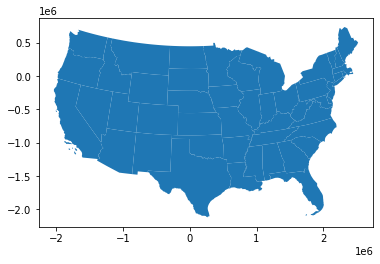

In [107]:
pres_2016_lower48_naea_gdf = president_2016_lower48_gdf.to_crs(epsg='2163')
pres_2016_lower48_naea_gdf.plot()

Visualize the "Republican" column with a nice "bwr" [colormap](https://matplotlib.org/tutorials/colors/colormaps.html).

In [92]:
pres_2016_lower48_naea_gdf['republican'].describe()

count    49.000000
mean      0.482186
std       0.126795
min       0.040704
25%       0.413504
50%       0.486716
75%       0.579410
max       0.686306
Name: republican, dtype: float64

In [95]:
pres_2016_lower48_naea_gdf.loc[pres_2016_lower48_naea_gdf['NAME'] == 'Michigan','republican']

42    0.474976
Name: republican, dtype: float64

<AxesSubplot:>

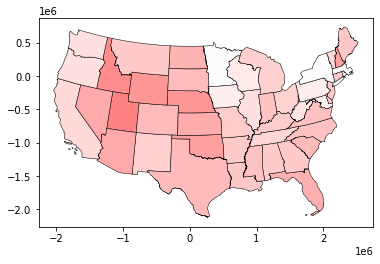

In [108]:
pres_2016_lower48_naea_gdf.plot(column='republican',cmap='bwr',vmin=0,vmax=1,edgecolor='k',lw=.5)